In [1]:
import os
import random

from PIL import Image

import numpy as np
import pandas as pd
from skimage.measure import block_reduce
from skimage.color import rgb2gray
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from utils import load_data

2024-04-08 11:29:58.486533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH_TO_TRAINING_DATA = 'data/train/'
PATH_TO_TEST_DATA = 'data/test/'
PATH_TO_VALID_DATA = 'data/valid/'

## Exploratory Data Analysis

In [3]:
nowildfire_names = os.listdir(PATH_TO_TRAINING_DATA + 'nowildfire/')
wildfire_names = os.listdir(PATH_TO_TRAINING_DATA + 'wildfire/')

### Class Balance

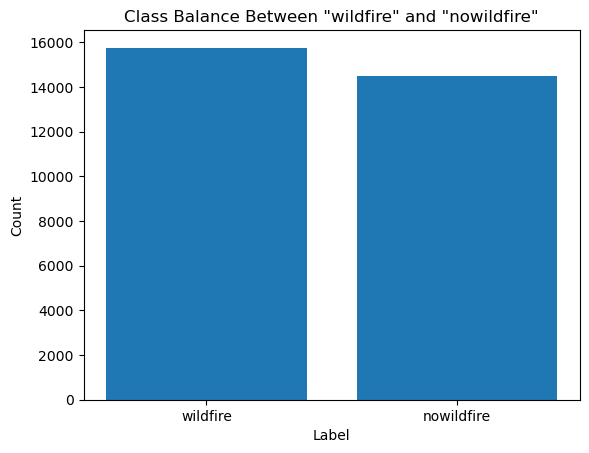

In [8]:
plt.bar(['wildfire', 'nowildfire'], [len(wildfire_names), len(nowildfire_names)])
plt.title('Class Balance Between "wildfire" and "nowildfire"')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Sample Images

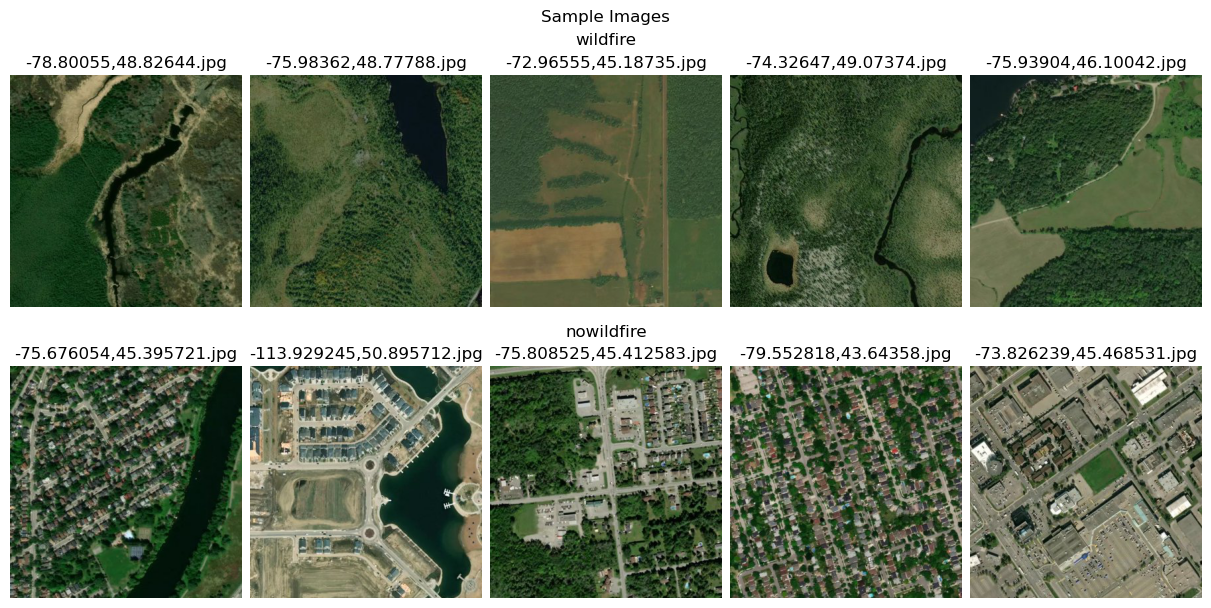

In [9]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
fig.suptitle('Sample Images')

labels = ['wildfire', 'nowildfire']
samples = {'wildfire': random.sample(wildfire_names, 5),
           'nowildfire': random.sample(nowildfire_names, 5)}

subfigs = fig.subfigures(nrows=2, ncols=1)

for row, subfig in enumerate(subfigs):
    label = labels[row]
    subfig.suptitle(label)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=5)
    for col, ax in enumerate(axs):
        file_name = samples[label][col]
        path = PATH_TO_TRAINING_DATA + label + '/' + file_name
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.set_title(file_name)
        ax.axis('off')

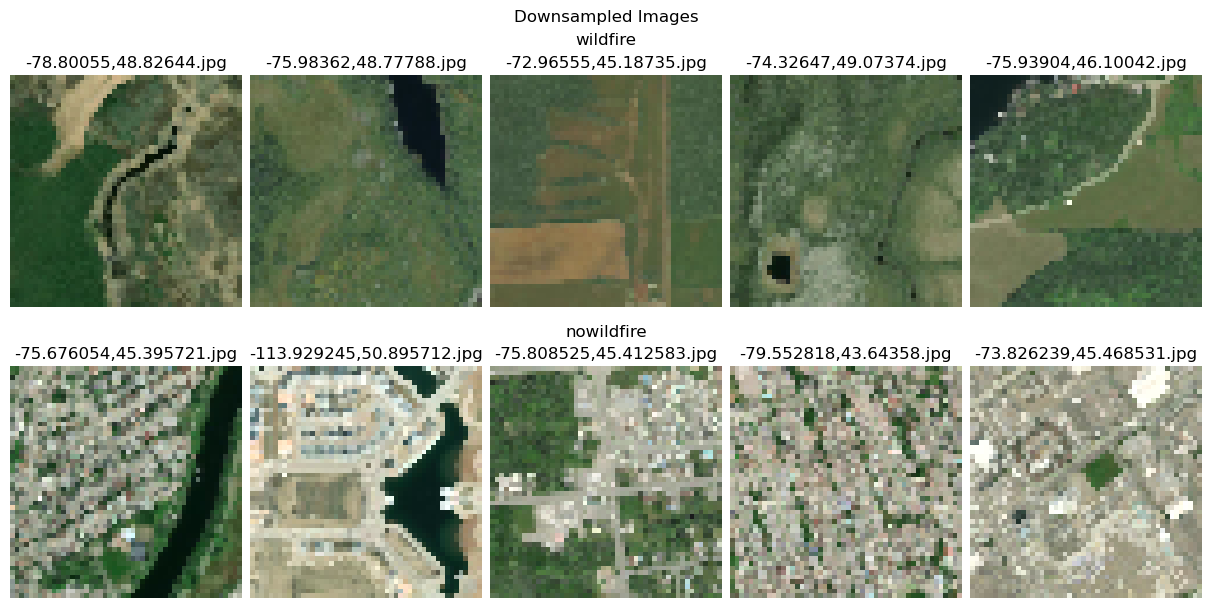

In [10]:
DOWNSAMPLE_FACTOR = 7

fig = plt.figure(figsize=(12, 6), constrained_layout=True)
fig.suptitle('Downsampled Images')

subfigs = fig.subfigures(nrows=2, ncols=1)

for row, subfig in enumerate(subfigs):
    label = labels[row]
    subfig.suptitle(label)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=5)
    for col, ax in enumerate(axs):
        file_name = samples[label][col]
        path = PATH_TO_TRAINING_DATA + label + '/' + file_name
        img = mpimg.imread(path)
        img_reduced = block_reduce(img, block_size=(DOWNSAMPLE_FACTOR, DOWNSAMPLE_FACTOR, 1), func=np.max)
        #print(img, img_reduced)
        ax.imshow(img_reduced)
        ax.set_title(file_name)
        ax.axis('off')

### RGB Distribution

In [14]:
images_reshaped = images.reshape(images.shape[0], -1, images.shape[-1])
avg_values = np.mean(images_reshaped, axis=1)

wildfire_indices = np.where(labels == 'wildfire')
avg_values_wildfire = avg_values[wildfire_indices]

nowildfire_indices = np.where(labels == 'nowildfire')
avg_values_nowildfire = avg_values[nowildfire_indices]

/Users/MarlonFu/opt/anaconda3/envs/207/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/MarlonFu/opt/anaconda3/envs/207/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/MarlonFu/opt/anaconda3/envs/207/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/MarlonFu/opt/anaconda3/envs/207/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

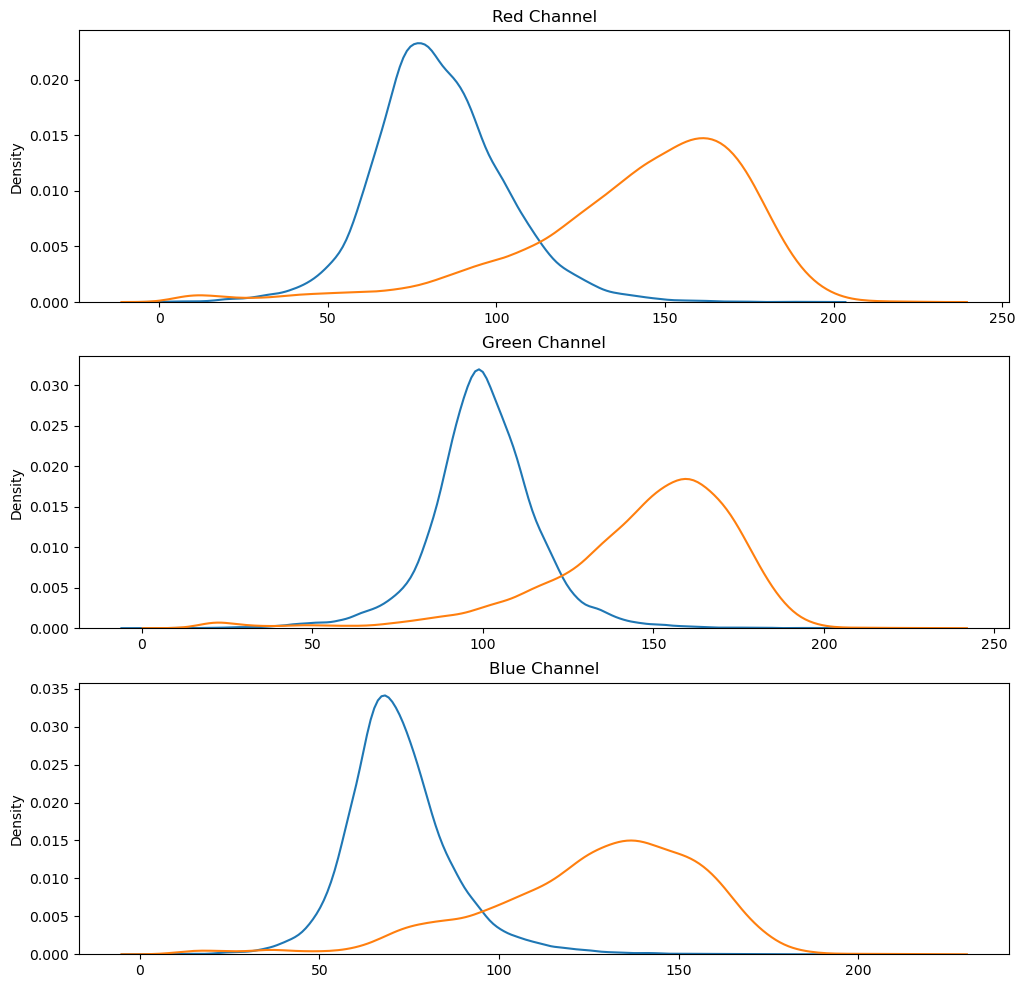

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

channels = ['Red Channel', 'Green Channel', 'Blue Channel']
for i in range(len(channels)):
    channel = channels[i]
    sns.kdeplot(ax=axs[i], data=avg_values_wildfire[:,i])
    sns.kdeplot(ax=axs[i], data=avg_values_nowildfire[:,i])
    axs[i].set_title(channel)

## Load Data

In [3]:
%%time
# Load training images and labels. Print shapes
X_train, y_train = load_data(PATH_TO_TRAINING_DATA)
print("Shape of training images ", X_train.shape)
print("Shape of training labels ", y_train.shape)

# Load validation images and labels. Print shapes
X_val, y_val = load_data(PATH_TO_VALID_DATA)
print("Shape of validation images ", X_val.shape)
print("Shape of validation labels ", y_val.shape)

# Load test images and labels. Print shapes
X_test, y_test = load_data(PATH_TO_TEST_DATA)
print("Shape of test images ", X_test.shape)
print("Shape of test labels ", y_test.shape)

3 images failed to load.
Shape of training images  (30249, 50, 50, 3)
Shape of training labels  (30249,)
2 images failed to load.
Shape of validation images  (6300, 50, 50, 3)
Shape of validation labels  (6300,)
CPU times: user 3min 58s, sys: 6.53 s, total: 4min 5s
Wall time: 4min 8s


## Feature Engineering

In [4]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2] * X_val.shape[3])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

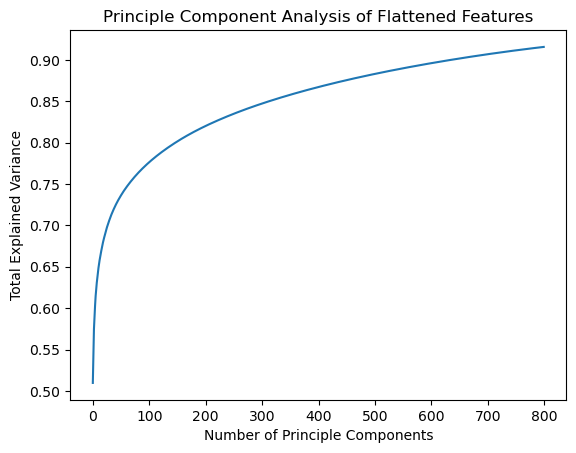

In [6]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

pca = PCA(n_components = 800)
 
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
 
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.xlabel('Number of Principle Components')
plt.ylabel('Total Explained Variance')
plt.title('Principle Component Analysis of Flattened Features')
plt.show()

## Logistic Regression

This model is based on the following methodologies: 
- https://medium.com/@gryangalario/image-classification-using-logistic-regression-on-the-american-sign-language-mnist-9c6522242ddf
- https://medium.com/@MudSnail/the-importance-of-logistic-regression-in-image-classification-1966d07e7a0c
- https://machinelearningmastery.com/logistic-regression-for-image-classification-using-opencv/

In [7]:
%%time

from sklearn.linear_model import LogisticRegression
logreg =  LogisticRegression()
logreg.fit(X_train, y_train)

CPU times: user 22.1 s, sys: 402 ms, total: 22.5 s
Wall time: 2.94 s


/Users/MarlonFu/opt/anaconda3/envs/207/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
val_predictions = logreg.predict(X_val)
test_predictions = logreg.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, logreg.predict(X_train))
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print('Train Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Accuracy:', test_accuracy)

Train Accuracy: 0.905352243049357
Validation Accuracy: 0.896984126984127


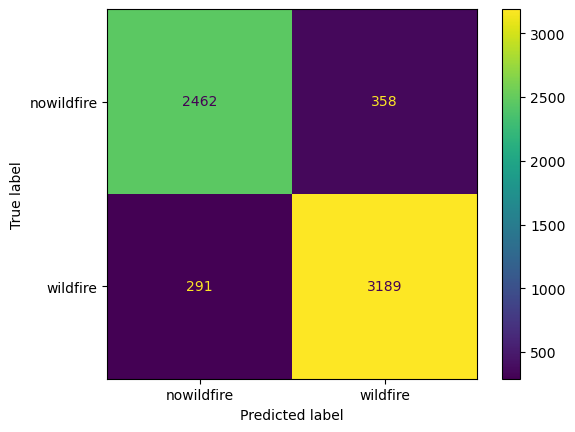

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, test_predictions, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()